In [7]:
import os
from skimage import io
import csv
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np
%matplotlib inline

In [12]:
# Load the CSV file
csv_path = 'train_labeled.csv'
data = pd.read_csv(csv_path)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Calculate the number of rows for each split
total_rows = len(data)
train_rows = int(total_rows * 0.85)
test_rows = total_rows - train_rows

# Split the data into two parts
train_data = data.iloc[:train_rows]
test_data = data.iloc[train_rows:]

# Save the split data to new CSV files
train_csv_path = 'train_data.csv'
test_csv_path = 'val_data.csv'

train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)

In [13]:
RESOLUTION = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=RESOLUTION, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=transforms.InterpolationMode.BICUBIC),
    v2.RandomRotation(20),  # Randomly rotate images by a certain degree
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),  # Transform to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

# Define a transform for the validation data without data augmentation
val_transform = transforms.Compose([
    v2.Resize((RESOLUTION, RESOLUTION), interpolation=transforms.InterpolationMode.BICUBIC),  # Resize images to a common size
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),  # Transform to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

In [14]:
train_csv = 'train_data.csv'
val_csv = 'val_data.csv'
labeled_path = 'train/labeled'

class CustomDataset(Dataset):
    def __init__(self, csv_file, train_path, transform=None):
        self.train_labeled = train_path
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.pseudo_label_data = []

    def __len__(self):
        return len(self.df) + len(self.pseudo_label_data)
        
    def add_psudo_data(self, data):
        self.pseudo_label_data.extend(data)

    def __getitem__(self, idx):
        if idx < len(self.df):
            img_path = self.train_labeled + '/' + self.df.image[idx]
            image = datasets.folder.default_loader(img_path)
            label = self.df.id[idx]
        else:
            image = datasets.folder.default_loader(self.pseudo_label_data[idx-len(self.df)][1])
            label = int(self.pseudo_label_data[idx-len(self.df)][0])
        if self.transform:
            image = self.transform(image)

        return image, label
labeled_train_dataset = CustomDataset(train_csv, labeled_path, train_transform)
labeled_val_dataset = CustomDataset(val_csv, labeled_path, val_transform)

In [15]:
print(len(labeled_train_dataset), len(labeled_val_dataset))

8375 1479


In [16]:
BATCH_SIZE = 32
train_label_loader = DataLoader(dataset=labeled_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_label_loader = DataLoader(dataset=labeled_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


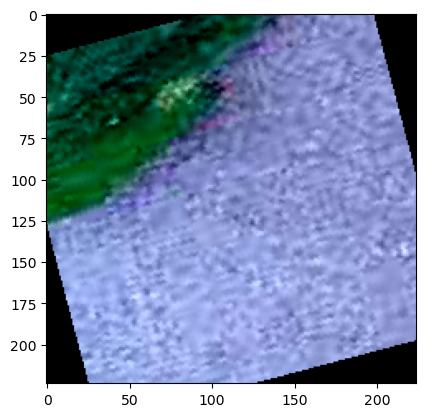

In [17]:
def imshow(img, un):
    if(un):
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_iter = iter(train_label_loader)
images, labels = next(train_iter)
print(labels[0])
imshow(make_grid(images[0]), True)

In [18]:
unlabeled_path = 'train/unlabeled'

# For the test set, since there are no labels, we need to create a custom DataSet.
class UnlabeledDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super(UnlabeledDataset, self).__init__(root, transform=transform)
        self.images = [os.path.join(root, img) for img in os.listdir(root)]

    def __getitem__(self, index):
        image_path = self.images[index]
        image = datasets.folder.default_loader(image_path)  # default loader is PIL.Image.open
        if self.transform:
            image = self.transform(image)
        return image, str(image_path)

    def __len__(self):
        return len(self.images)
    # def remove_from_ds(image_path):
        
        

# Create a dataset for your test data
unlabeled_ds = UnlabeledDataset(root=unlabeled_path, transform=val_transform)

# Create a DataLoader for your test set
unlabel_loader = DataLoader(dataset=unlabeled_ds, batch_size=BATCH_SIZE, shuffle=True)
print(len(unlabeled_ds))

22995


In [19]:
from torchvision.models import convnext_small
model_convNext = convnext_small(weights=None)

In [21]:
class ModifiedConvNext(nn.Module):
    def __init__(self, model_conv):
        super(ModifiedConvNext, self).__init__()
        self.model = model_conv

        self.new_head = nn.Sequential(
            nn.Linear(1000, 135),
        )

    def forward(self, x):
        x = self.model(x)
        x = self.new_head(x)
        return x

# Create the modified model
model = ModifiedConvNext(model_convNext)
model

ModifiedConvNext(
  (model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((9

In [22]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
def eval_unlabeled_data(model, dataloader, device, thrs = 0.95):
    psudo_data = []
    model.eval()
    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as vepoch:
            for images, path in vepoch:
                vepoch.set_description(f"Unlabeled Epoch")
                images = images.to(device)
                outputs = model(images)
                probs = nn.Softmax(dim=1)
                probs = probs(outputs)
                max_probs, targets = torch.max(probs, dim=1)
                mask = max_probs > thrs
                psudo_data.extend([(targets[i], path[i]) for i in range(len(targets)) if mask[i]])
            print('psudo data len', len(psudo_data))
    return psudo_data

In [24]:
torch.cuda.empty_cache()

In [27]:
# Send the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10

# Lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_label_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            tepoch.set_postfix(loss=(running_loss / (tepoch.n + 1)), accuracy=(correct_predictions / total_predictions))

    # Calculate and print loss and accuracy for the training phase
    epoch_loss = running_loss / len(train_label_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Run inference on unlabeled data and add to labeled dataset
    data = eval_unlabeled_data(model, unlabel_loader, device)
    labeled_train_dataset.add_psudo_data(data)
    print('new ds len', len(labeled_train_dataset))
    train_label_loader = DataLoader(dataset=labeled_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Remove data that has been given pseudo labels from our unlabeled dataset 
    set_data = set([x[1] for x in data])
    unlabeled_ds.images = [x for x in unlabeled_ds.images if x not in set_data]
    print('new unlabled ds len', len(unlabeled_ds.images))
    unlabel_loader = DataLoader(dataset=unlabeled_ds, batch_size=BATCH_SIZE, shuffle=True)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    # Disable gradient calculation for validation to save memory and computations
    with torch.no_grad():
        with tqdm(val_label_loader, unit="batch") as vepoch:
            for images, labels in vepoch:
                vepoch.set_description(f"Validation Epoch {epoch+1}/{num_epochs}")

                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

                # Update progress bar
                vepoch.set_postfix(val_loss=(val_running_loss / (vepoch.n + 1)), val_accuracy=(val_correct_predictions / val_total_predictions))

    # Calculate and print loss and accuracy for the validation phase
    val_epoch_loss = val_running_loss / len(val_label_loader.dataset)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    if val_epoch_accuracy > best_val:
        best_val = val_epoch_accuracy
        torch.save(model.state_dict(), 'ConvNext_model.pt')

    # Print summary for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

Unlabeled Epoch: 100%|██████████| 719/719 [12:10<00:00,  1.02s/batch]


psudo data len 0
new ds len 8375
new unlabled ds len 22995


Validation Epoch 1/10: 100%|██████████| 47/47 [00:47<00:00,  1.01s/batch, val_accuracy=0.176, val_loss=112]


Epoch [1/10], Train Loss: 3.6770, Train Accuracy: 0.1550, Val Loss: 3.5621, Val Accuracy: 0.1765


Unlabeled Epoch: 100%|██████████| 719/719 [11:21<00:00,  1.06batch/s]


psudo data len 17
new ds len 8392
new unlabled ds len 22978


Validation Epoch 2/10: 100%|██████████| 47/47 [00:44<00:00,  1.05batch/s, val_accuracy=0.135, val_loss=112]


Epoch [2/10], Train Loss: 3.5709, Train Accuracy: 0.1758, Val Loss: 3.5525, Val Accuracy: 0.1346


Unlabeled Epoch: 100%|██████████| 719/719 [11:40<00:00,  1.03batch/s]


psudo data len 368
new ds len 8760
new unlabled ds len 22610


Validation Epoch 3/10: 100%|██████████| 47/47 [00:46<00:00,  1.01batch/s, val_accuracy=0.225, val_loss=106]


Epoch [3/10], Train Loss: 3.4618, Train Accuracy: 0.2011, Val Loss: 3.3540, Val Accuracy: 0.2252


Unlabeled Epoch: 100%|██████████| 707/707 [11:56<00:00,  1.01s/batch]


psudo data len 319
new ds len 9079
new unlabled ds len 22291


Validation Epoch 4/10: 100%|██████████| 47/47 [00:47<00:00,  1.01s/batch, val_accuracy=0.151, val_loss=113]


Epoch [4/10], Train Loss: 3.2446, Train Accuracy: 0.2485, Val Loss: 3.6029, Val Accuracy: 0.1515


Unlabeled Epoch: 100%|██████████| 697/697 [10:13<00:00,  1.14batch/s]


psudo data len 134
new ds len 9213
new unlabled ds len 22157


Validation Epoch 5/10: 100%|██████████| 47/47 [00:41<00:00,  1.12batch/s, val_accuracy=0.193, val_loss=110]


Epoch [5/10], Train Loss: 3.0841, Train Accuracy: 0.2905, Val Loss: 3.4798, Val Accuracy: 0.1934


Epoch 6/10:  37%|███▋      | 106/288 [13:51<23:47,  7.84s/batch, accuracy=0.309, loss=96.2]


KeyboardInterrupt: 

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Model's evaluation mode
model.eval()

test_predictions = []

# Assuming the model is already in evaluation mode and device is defined
with torch.no_grad():
    for images, paths in tqdm(test_loader, desc='Predicting labels'):
        images = images.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Go through the batch and add to our prediction list, including image paths
        for path, label in zip(paths, predicted):
            test_predictions.append((Path(path).name, label))  # Appending a tuple of filename and label

with open('test_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image', 'id'])
    writer.writerows(test_predictions)  # Writing all predictions at once